# Prédiction de l'Occupation Hospitalière

#### Objectif : Anticiper le nombre de lits occupés pour optimiser la gestion des ressources 

#### Source :  [Données Kaggle – Hospital Beds Management](https://www.kaggle.com/datasets/jaderz/hospital-beds-management)

#### Document produit par le groupe de Harry Boisselot et Benoit Catry S5A2
#### Etudiants à l'IUT NFC 2025-2026 

## partie initialisation
#### Import

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

#### Dataset

In [31]:
df = pd.read_csv("services_weekly.csv")

## Analyse du dataset et Préparation

In [32]:
print("Aperçu du DataFrame :")
print(df.head(), "\n")

Aperçu du DataFrame :
   week  month           service  available_beds  patients_request  \
0     1      1         emergency              32                76   
1     1      1           surgery              45               130   
2     1      1  general_medicine              37               201   
3     1      1               ICU              22                31   
4     2      1         emergency              28               169   

   patients_admitted  patients_refused  patient_satisfaction  staff_morale  \
0                 32                44                    67            70   
1                 45                85                    83            78   
2                 37               164                    97            43   
3                 22                 9                    84            91   
4                 28               141                    75            64   

  event  
0  none  
1   flu  
2   flu  
3   flu  
4  none   



In [61]:
print("Info :")
print(df.info(), "\n")

Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   week                  208 non-null    int64         
 1   month                 208 non-null    int64         
 2   service               208 non-null    object        
 3   available_beds        208 non-null    int64         
 4   patients_request      208 non-null    int64         
 5   patients_admitted     208 non-null    int64         
 6   patients_refused      208 non-null    int64         
 7   patient_satisfaction  208 non-null    int64         
 8   staff_morale          208 non-null    int64         
 9   event                 208 non-null    object        
 10  date                  208 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(8), object(2)
memory usage: 18.0+ KB
None 



In [34]:
print("Description numérique :")
print(df.describe(include="all"), "\n")

Description numérique :
              week       month    service  available_beds  patients_request  \
count   208.000000  208.000000        208      208.000000        208.000000   
unique         NaN         NaN          4             NaN               NaN   
top            NaN         NaN  emergency             NaN               NaN   
freq           NaN         NaN         52             NaN               NaN   
mean     26.500000    6.923077        NaN       30.346154         64.870192   
std      15.044539    3.634755        NaN       15.172929         58.738572   
min       1.000000    1.000000        NaN        8.000000          5.000000   
25%      13.750000    4.000000        NaN       18.000000         23.750000   
50%      26.500000    7.000000        NaN       27.500000         49.000000   
75%      39.250000   10.000000        NaN       40.000000         86.000000   
max      52.000000   12.000000        NaN       74.000000        388.000000   

        patients_admitted  

##### Commentaire :
**Qualité des données :** 208 entrées, 0 valeur manquante. Il couvre une année complète (52 semaines) pour 4 services.

**Autre :** max 388 patients, max 74 lits,  patients refusés en moyenne  36 par semaine. La colonne event indique la présence d'épidémies ("flu").

#### Préparation 

In [35]:
BASE_DATE = pd.to_datetime("2024-01-01")
df["date"] = BASE_DATE + pd.to_timedelta(df["week"] - 1, unit="W")

# Série hebdomadaire globale = somme sur tous les services
serie = (
    df.groupby("date")["patients_admitted"]
      .sum()
      .sort_index()
)

# On impose une fréquence hebdomadaire (lundi)
serie = serie.asfreq("W-MON")

print(f"Nb de valeurs manquantes (après asfreq, avant ffill) : {serie.isna().sum()}")

# Gestion des NA : propagation de la dernière valeur connue (ffill)
serie = serie.ffill()

print(f"Nb de valeurs manquantes (après ffill) : {serie.isna().sum()}\n")

print("Fréquence inférée de l'index :")
print(serie.index.inferred_freq, "\n")

print("Période couverte et taille de la série :")
print("Date min :", serie.index.min())
print("Date max :", serie.index.max())
print("Nombre d'observations :", serie.size, "\n")

Nb de valeurs manquantes (après asfreq, avant ffill) : 0
Nb de valeurs manquantes (après ffill) : 0

Fréquence inférée de l'index :
W-MON 

Période couverte et taille de la série :
Date min : 2024-01-01 00:00:00
Date max : 2024-12-23 00:00:00
Nombre d'observations : 52 



In [36]:
print("Premières semaines :")
print(serie.head(10), "\n")

print("Dernières semaines :")
print(serie.tail(10), "\n")

Premières semaines :
date
2024-01-01    136
2024-01-08    104
2024-01-15    116
2024-01-22    151
2024-01-29    104
2024-02-05    142
2024-02-12    153
2024-02-19    114
2024-02-26     99
2024-03-04     98
Freq: W-MON, Name: patients_admitted, dtype: int64 

Dernières semaines :
date
2024-10-21    108
2024-10-28    124
2024-11-04    122
2024-11-11    127
2024-11-18    138
2024-11-25    116
2024-12-02    131
2024-12-09    153
2024-12-16    168
2024-12-23    152
Freq: W-MON, Name: patients_admitted, dtype: int64 



In [37]:
print("Statistiques descriptives hebdomadaires :")
print(serie.describe(), "\n")

Statistiques descriptives hebdomadaires :
count     52.000000
mean     112.519231
std       23.051937
min       76.000000
25%       97.250000
50%      110.500000
75%      127.250000
max      168.000000
Name: patients_admitted, dtype: float64 



In [38]:
# Stats sur la somme mensuelle (agrégation mensuelle de la série hebdo)
serie_mensuelle = serie.resample("ME").sum()
print("Statistiques descriptives sur les totaux mensuels :")
print(serie_mensuelle.describe(), "\n")

Statistiques descriptives sur les totaux mensuels :
count     12.000000
mean     487.583333
std       91.563647
min      360.000000
25%      412.250000
50%      502.000000
75%      532.000000
max      627.000000
Name: patients_admitted, dtype: float64 



#### Commentaire : 

**Série temporelle** continue de 52 semaines (Jan-Déc 2024).

**Amplitude** Min 76, Max 168.

**écart-type** 23.

**Moyenne** 112.

#### Somme sur tous les services


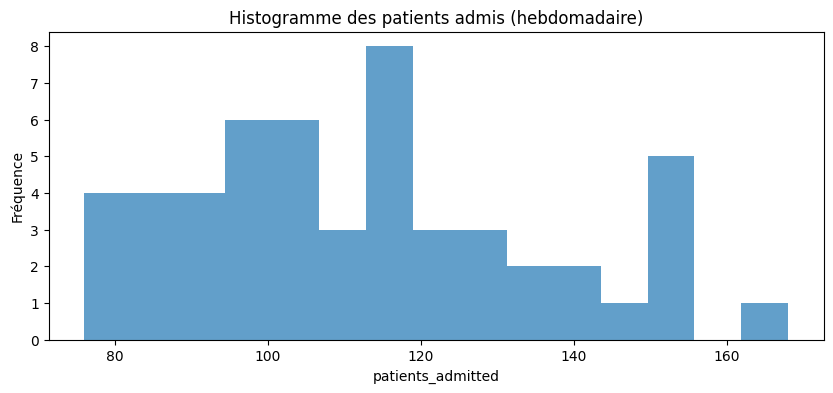

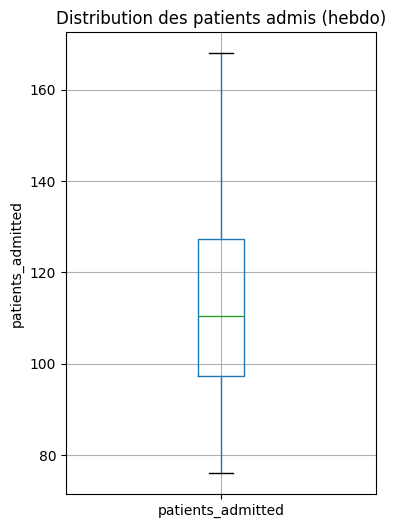

In [39]:
plt.figure(figsize=(10, 4))
serie.plot(kind="hist", bins=15, alpha=0.7)
plt.title("Histogramme des patients admis (hebdomadaire)")
plt.xlabel("patients_admitted")
plt.ylabel("Fréquence")
plt.show()

plt.figure(figsize=(4, 6))
serie.to_frame("patients_admitted").boxplot()
plt.title("Distribution des patients admis (hebdo)")
plt.ylabel("patients_admitted")
plt.show()

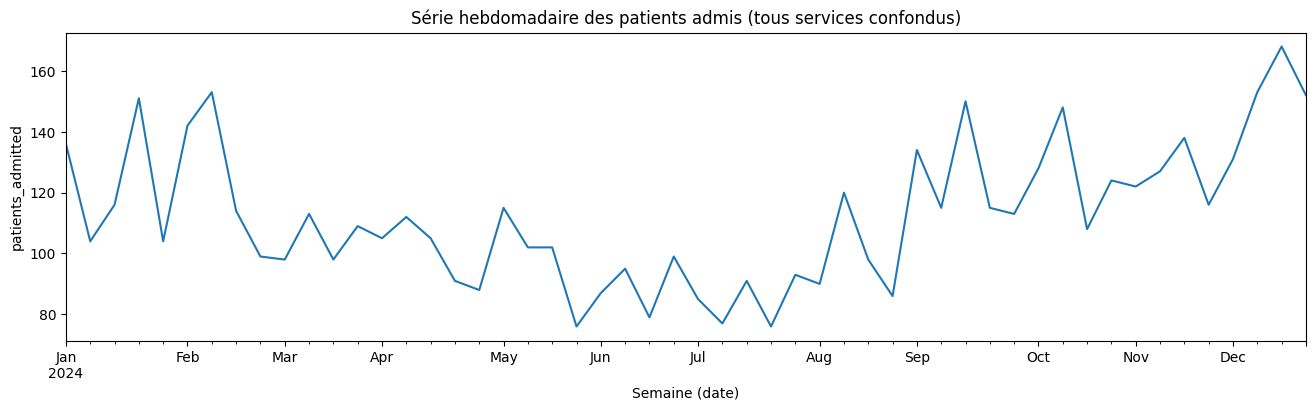

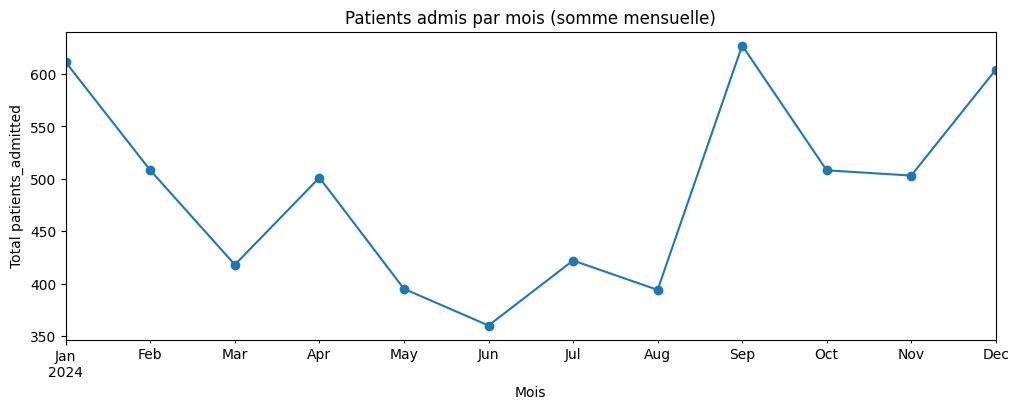

<Figure size 600x400 with 0 Axes>

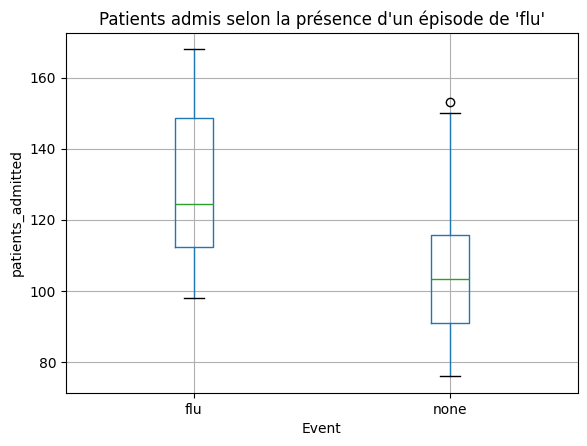

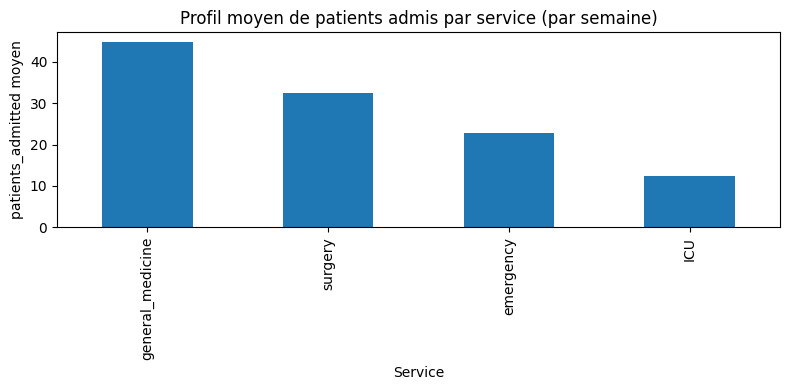

In [40]:
plt.figure(figsize=(16, 4))
serie.plot()
plt.title("Série hebdomadaire des patients admis (tous services confondus)")
plt.xlabel("Semaine (date)")
plt.ylabel("patients_admitted")
plt.show()

plt.figure(figsize=(12, 4))
serie_mensuelle.plot(marker="o")
plt.title("Patients admis par mois (somme mensuelle)")
plt.xlabel("Mois")
plt.ylabel("Total patients_admitted")
plt.show()

if "event" in df.columns:
    weekly_event = (
        df.groupby("date")["event"]
          .agg(lambda x: "flu" if "flu" in x.values else "none")
          .reindex(serie.index)
    )

    tmp = pd.DataFrame({
        "patients_admitted": serie,
        "event": weekly_event
    })

    plt.figure(figsize=(6, 4))
    tmp.boxplot(by="event", column="patients_admitted")
    plt.suptitle("")
    plt.title("Patients admis selon la présence d'un épisode de 'flu'")
    plt.xlabel("Event")
    plt.ylabel("patients_admitted")
    plt.show()

service_profile = (
    df.groupby("service")["patients_admitted"]
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(8, 4))
service_profile.plot(kind="bar")
plt.title("Profil moyen de patients admis par service (par semaine)")
plt.xlabel("Service")
plt.ylabel("patients_admitted moyen")
plt.tight_layout()
plt.show()

In [41]:
print("Statistiques globales hebdomadaires :")
print(serie.describe(), "\n")

print("Statistiques mensuelles (totaux) :")
print(serie_mensuelle.describe(), "\n")

print("Niveau de demande en semaine de pointe (approx) :")
print(" - max hebdomadaire :", serie.max())
print(" - quantile 0.95   :", serie.quantile(0.95))

Statistiques globales hebdomadaires :
count     52.000000
mean     112.519231
std       23.051937
min       76.000000
25%       97.250000
50%      110.500000
75%      127.250000
max      168.000000
Name: patients_admitted, dtype: float64 

Statistiques mensuelles (totaux) :
count     12.000000
mean     487.583333
std       91.563647
min      360.000000
25%      412.250000
50%      502.000000
75%      532.000000
max      627.000000
Name: patients_admitted, dtype: float64 

Niveau de demande en semaine de pointe (approx) :
 - max hebdomadaire : 168
 - quantile 0.95   : 152.45


## modele

### Feature et Préparation des Données

In [42]:
df = pd.read_csv("services_weekly.csv")
BASE_DATE = pd.to_datetime("2024-01-01")
df["date"] = BASE_DATE + pd.to_timedelta(df["week"] - 1, unit="W")

# Série hebdomadaire globale = somme sur tous les services
serie = (
    df.groupby("date")["patients_admitted"]
      .sum()
      .sort_index()
)

# On impose une fréquence hebdomadaire (lundi)
serie = serie.asfreq("W-MON")


def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

df_features = serie.to_frame(name="y") 

In [43]:


df_features["week"] = df_features.index.isocalendar().week.astype(int)
df_features["month"] = df_features.index.month
df_features["year"] = df_features.index.year

weekly_event = (
    df.groupby("date")["event"]
      .agg(lambda x: "flu" if "flu" in x.values else "none")
      .reindex(df_features.index)
)

df_features["flu"] = (weekly_event == "flu").astype(int)

for lag in [1, 2, 3, 4, 8, 12]:
    df_features[f"lag_{lag}"] = df_features["y"].shift(lag)

df_features["roll_mean_4"] = df_features["y"].shift(1).rolling(4).mean()
df_features["roll_std_4"]  = df_features["y"].shift(1).rolling(4).std()

df_features = df_features.dropna()

X = df_features.drop(columns=["y"])
y = df_features["y"]

print("Features disponibles :")
print(X.columns.tolist(), "\n")
print("Aperçu du dataset supervisé :")
print(df_features.head(), "\n")


Features disponibles :
['week', 'month', 'year', 'flu', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_8', 'lag_12', 'roll_mean_4', 'roll_std_4'] 

Aperçu du dataset supervisé :
              y  week  month  year  flu  lag_1  lag_2  lag_3  lag_4  lag_8  \
date                                                                         
2024-03-25  109    13      3  2024    0   98.0  113.0   98.0   99.0  104.0   
2024-04-01  105    14      4  2024    0  109.0   98.0  113.0   98.0  142.0   
2024-04-08  112    15      4  2024    1  105.0  109.0   98.0  113.0  153.0   
2024-04-15  105    16      4  2024    0  112.0  105.0  109.0   98.0  114.0   
2024-04-22   91    17      4  2024    0  105.0  112.0  105.0  109.0   99.0   

            lag_12  roll_mean_4  roll_std_4  
date                                         
2024-03-25   136.0       102.00    7.348469  
2024-04-01   104.0       104.50    7.681146  
2024-04-08   116.0       106.25    6.396614  
2024-04-15   151.0       106.00    6.055301  
2024-

Split temporel (75% / 25%) popur entrainement

In [44]:
split_idx = int(len(df_features) * 0.75)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train :", X_train.shape)
print("Test  :", X_test.shape, "\n")

Train : (30, 12)
Test  : (10, 12) 



### Test de model

MODÈLE                              | MAE        | RMSE      
------------------------------------------------------------
XGBoost (1)                         | 18.15       | 22.92
XGBoost (2)                         | 18.26       | 23.16
XGBoost (3)                         | 17.66       | 22.98
Random Forest (1)                   | 15.42       | 18.52
Random Forest (2)                   | 15.50       | 18.95
Random Forest (3)                   | 15.89       | 18.45
ARIMA (2,1,2)                       | ... en cours ...


/home/benoit/Documents/IUT-main/Troisieme_année/IA/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2,1,2)                       | 33.77       | 38.39


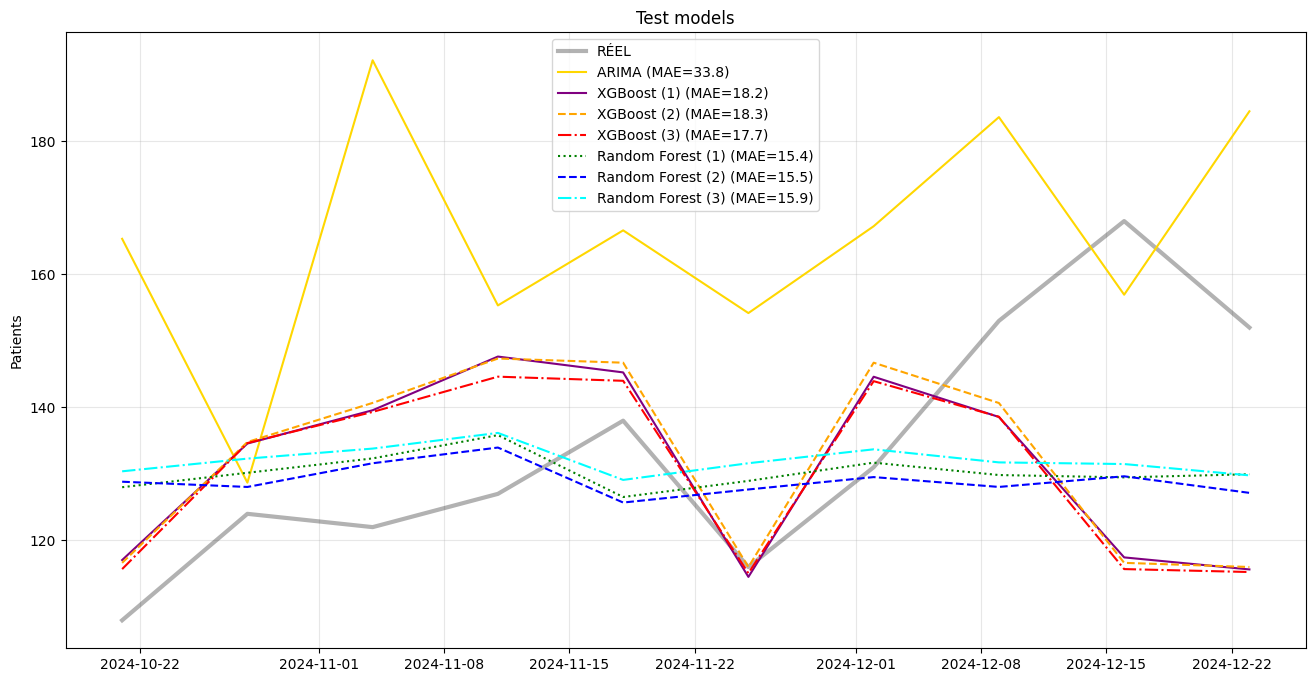


=== CLASSEMENT ===
              Modèle        MAE       RMSE
3  Random Forest (1)  15.418000  18.518445
4  Random Forest (2)  15.503600  18.952379
5  Random Forest (3)  15.886583  18.447584
2        XGBoost (3)  17.658468  22.979437
0        XGBoost (1)  18.151400  22.920878
1        XGBoost (2)  18.258240  23.157798
6              ARIMA  33.771571  38.392809


In [45]:
models_ml = {
    "XGBoost (1)": XGBRegressor(
        n_estimators=1000, learning_rate=0.3, max_depth=4, 
         n_jobs=-1, random_state=42
    ),
    

    "XGBoost (2)": XGBRegressor(
        n_estimators=200, learning_rate=0.3, max_depth=5, 
        n_jobs=-1, random_state=42
    ),
    "XGBoost (3)": XGBRegressor(
        n_estimators=5000, learning_rate=0.001, max_depth=4, 
        n_jobs=-1, random_state=42
    ),

    "Random Forest (1)": RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1
    ),
    "Random Forest (2)": RandomForestRegressor(
        n_estimators=1000, random_state=42, n_jobs=-1
    ),
    "Random Forest (3)": RandomForestRegressor(
        n_estimators=100, max_depth=3, random_state=42, n_jobs=-1
    ),


}

results = []
preds_dict = {}

print(f"{'MODÈLE':<35} | {'MAE':<10} | {'RMSE':<10}")
print("-" * 60)


for name, model in models_ml.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    preds_dict[name] = preds
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds) ** 0.5
    results.append({"Modèle": name, "MAE": mae, "RMSE": rmse})
    
    print(f"{name:<35} | {mae:.2f}       | {rmse:.2f}")


print(f"{'ARIMA (2,1,2)':<35} | ... en cours ...")
try:
    exog_cols = ['flu', 'week', 'month', 'year']
    if all(col in X_train.columns for col in exog_cols):
        model_arima = ARIMA(y_train, exog=X_train[exog_cols], order=(2, 1, 2))
        model_fit = model_arima.fit()
        pred_arima = model_fit.forecast(steps=len(y_test), exog=X_test[exog_cols]).values
        
        preds_dict["ARIMA"] = pred_arima
        mae_arima = mean_absolute_error(y_test, pred_arima)
        rmse_arima = mean_squared_error(y_test, pred_arima) ** 0.5
        
        results.append({"Modèle": "ARIMA", "MAE": mae_arima, "RMSE": rmse_arima})
        print(f"{'ARIMA (2,1,2)':<35} | {mae_arima:.2f}       | {rmse_arima:.2f}")
except Exception as e:
    print(f"ARIMA ignoré : {e}")




df_res = pd.DataFrame(results).sort_values("MAE")

plt.figure(figsize=(16, 8))
plt.plot(y_test.index, y_test, label="RÉEL", color="black", linewidth=3, alpha=0.3)

selection = [
    "ARIMA",                        
    "XGBoost (1)", 
    "XGBoost (2)", 
    "XGBoost (3)",         
    "Random Forest (1)",
    "Random Forest (2)",
    "Random Forest (3)",
]

colors = ["gold", "purple", "orange", "red", "green", "blue", "cyan"]
styles = ["-", "-", "--", "-.", ":", "--", "-."]

for name, color, style in zip(selection, colors, styles):
    if name in preds_dict:
        if name in df_res["Modèle"].values:
            score = df_res[df_res["Modèle"] == name]["MAE"].values[0]
            lw = 3 if name == "Régression Linéaire" else 1.5
            plt.plot(y_test.index, preds_dict[name], 
                     label=f"{name} (MAE={score:.1f})", 
                     color=color, linestyle=style, linewidth=lw)

plt.title("Test models")
plt.ylabel("Patients")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== CLASSEMENT ===")
print(df_res)

#### Commenentaire :
Arina nul.

Pour les random forest, leur marge d'erreur est plus petit mais trop constent (faible variation) donc pas realiste.

Pour XGBoost, la marge d'erreur plus grande mais à chaque fois au dessus donc moins grave et arrive à suivre les tendances.

**Note :** Evité de prendre en compte le mois de décembre (cas particuler) 

**Choix :**  Xgboost 1 

### 4. TimeSeriesSplit pour validation glissante


In [46]:
tscv = TimeSeriesSplit(n_splits=5)

def evaluate_model(model):
    """Validation glissante uniquement sur le train."""
    maes, rmses = [], []
    for train_idx, val_idx in tscv.split(X_train):
        Xtr, Xval = X_train.iloc[train_idx], X_train.iloc[val_idx]
        ytr, yval = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(Xtr, ytr)
        pred = model.predict(Xval)

        maes.append(mean_absolute_error(yval, pred))
        rmses.append(rmse(yval, pred))

    return np.mean(maes), np.mean(rmses)

## 5.modèle XGBoost 

In [47]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

model_xgb = XGBRegressor(
    n_estimators=1000, learning_rate=0.3, max_depth=4, 
    n_jobs=-1, random_state=42
)

mae_val, rmse_val = evaluate_model(model_xgb)
print(f"[XGBoost best] Validation : MAE={mae_val:.2f}, RMSE={rmse_val:.2f}")

model_xgb.fit(X_train, y_train)

pred_test = model_xgb.predict(X_test)

rmse_test = rmse(y_test, pred_test)
mae_test = mean_absolute_error(y_test, pred_test)

print(f"[XGBoost best] Test : MAE={mae_test:.2f}, RMSE={rmse_test:.2f}\n")

[XGBoost best] Validation : MAE=15.65, RMSE=19.19
[XGBoost best] Test : MAE=18.15, RMSE=22.92



####  Visualisation : Test vs prédictions

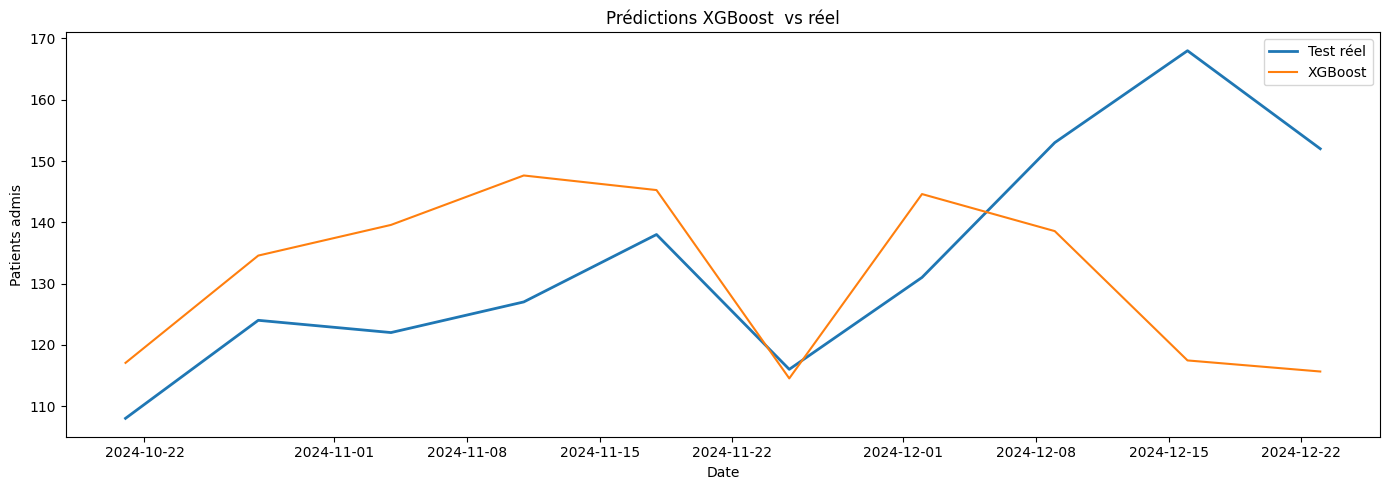

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(y_test, label="Test réel", linewidth=2)
plt.plot(X_test.index, pred_test, label="XGBoost")
plt.title("Prédictions XGBoost vs réel")
plt.xlabel("Date")
plt.ylabel("Patients admis")
plt.legend()
plt.tight_layout()
plt.show()

### Importance des features

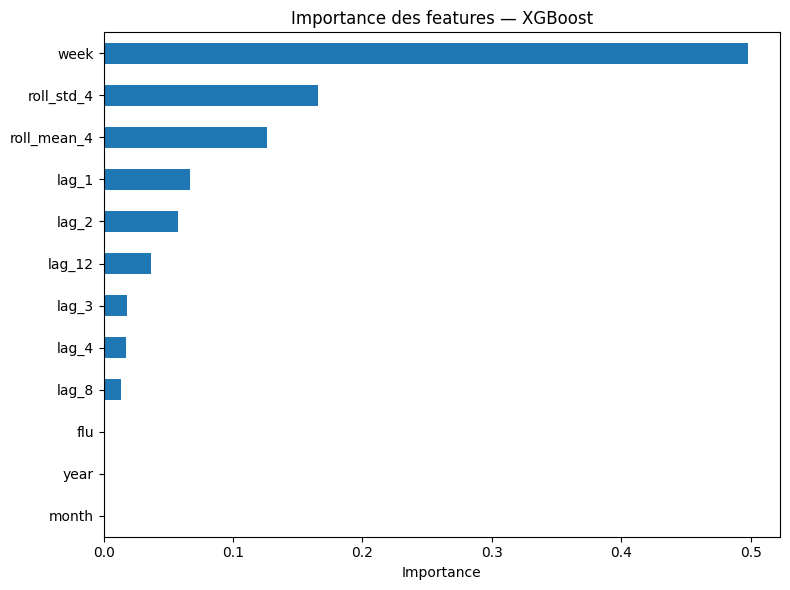

In [49]:
importances = pd.Series(model_xgb.feature_importances_, index=X_train.columns)

plt.figure(figsize=(8, 6))
importances.sort_values().tail(15).plot(kind="barh")
plt.title("Importance des features — XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Résumé Modèle

In [50]:
summary = pd.DataFrame({
    "Modèle": ["XGBoost"],
    "MAE validation": [mae_val],
    "RMSE validation": [rmse_val],
    "MAE test": [mae_test],
    "RMSE test": [rmse_test],
})

print("\nRésumé du modèle supervisé final")
print(summary)


Résumé du modèle supervisé final
    Modèle  MAE validation  RMSE validation  MAE test  RMSE test
0  XGBoost       15.654804        19.188387   18.1514  22.920878


#### Commentaire :

Erreur moyenne (MAE) de 15.6 patients pour une activité moyenne de 113, la marge d'erreur est d'environ 10%

RMSE (19.18) n'est pas beaucoup plus élevé que le MAE. Cela signifie qu'il y a très peu de valeurs aberrantes

## Utilisation du Models

Réentraînement sur TOUTES les données (X, y) et save du model pour pouvoir le réutiliser

In [51]:
model_xgb = XGBRegressor(
    n_estimators=1000, learning_rate=0.3, max_depth=4, 
    n_jobs=-1, random_state=42
)

print(f"[XGBoost best] Test : MAE={mae_test:.2f}, RMSE={rmse_test:.2f}\n")
model_xgb.fit(X, y)

joblib.dump(model_xgb, "xgb_hospital.pkl")
print("Modèle sauvegardé dans xgb_hospital.pkl")


[XGBoost best] Test : MAE=18.15, RMSE=22.92

Modèle sauvegardé dans xgb_hospital.pkl


## methode 

### Fonction de prédiction à partir d'une date donnée

In [52]:
def predict_weeks_from_date(start_date, horizon=4, flu=0):
    """
    start_date : str ou Timestamp -> date à partir de laquelle on veut des prédictions
    horizon    : int -> nombre de semaines à prédire à partir de cette date
    flu        : 0 ou 1 -> indique si on veut simuler un épisode de grippe pour les semaines futures

    La fonction gère automatiquement le cas où start_date > dernière date observée :
    - elle prédit d'abord les semaines manquantes
    - puis renvoie uniquement les 'horizon' semaines à partir de start_date
    """

    start_date = pd.to_datetime(start_date)

    last_date = df_features.index[-1]

    history_y = list(df_features["y"].iloc[-12:])

    if start_date <= last_date:
        n_skip = 0
    else:
        delta_days = (start_date - last_date).days
        n_skip = int(np.ceil(delta_days / 7))

    total_steps = n_skip + horizon  
    all_dates = []
    all_preds = []
    xgb = joblib.load("xgb_hospital.pkl")
    
    for step in range(1, total_steps + 1):
        current_date = last_date + pd.Timedelta(weeks=step)
        all_dates.append(current_date)

        iso = current_date.isocalendar()
        week = int(iso.week)
        month = current_date.month
        year = current_date.year

        flu_flag = int(flu)

        lag_1 = history_y[-1]
        lag_2 = history_y[-2] if len(history_y) >= 2 else lag_1
        lag_3 = history_y[-3] if len(history_y) >= 3 else lag_2
        lag_4 = history_y[-4] if len(history_y) >= 4 else lag_3
        lag_8 = history_y[-8] if len(history_y) >= 8 else history_y[0]
        lag_12 = history_y[-12] if len(history_y) >= 12 else history_y[0]

        last4 = history_y[-4:] if len(history_y) >= 4 else history_y
        roll_mean_4 = np.mean(last4)
        roll_std_4  = np.std(last4, ddof=0)

        row = pd.DataFrame([{
            "week": week,
            "month": month,
            "year": year,
            "flu": flu_flag,
            "lag_1": lag_1,
            "lag_2": lag_2,
            "lag_3": lag_3,
            "lag_4": lag_4,
            "lag_8": lag_8,
            "lag_12": lag_12,
            "roll_mean_4": roll_mean_4,
            "roll_std_4": roll_std_4,
        }], index=[current_date])

        row = row[X.columns]

        y_hat = xgb.predict(row)[0]
        all_preds.append(y_hat)

        history_y.append(y_hat)

    df_all_future = pd.DataFrame({
        "date": all_dates,
        "prediction_patients_admitted": all_preds
    }).set_index("date")

    df_from_start = df_all_future[df_all_future.index >= start_date].iloc[:horizon]

    return df_from_start


### test methode :

In [53]:
df_future_juin = predict_weeks_from_date("2025-02-02", horizon=6)
print(df_future_juin)

            prediction_patients_admitted
date                                    
2025-02-03                    110.682182
2025-02-10                    109.776360
2025-02-17                    109.751762
2025-02-24                    107.060707
2025-03-03                    111.179314
2025-03-10                    107.080391


110.682182
2025-02-10                    109.776360
2025-02-17                    109.751762
2025-02-24                    107.060707
2025-03-03                    111.179314
2025-03-10                    107.080391

### methode date + nb de personne 

In [54]:
# Fonction : prédire les semaines à venir à partir d'une date
#           et du nombre actuel de patients


def predict_from_current(start_date, current_y, horizon=4, flu=0):
    """
    start_date : str ou Timestamp -> date correspondant à la semaine actuelle
    current_y  : float/int -> nombre de patients admis cette semaine-là (valeur actuelle)
    horizon    : int -> nombre de semaines à prédire après start_date
    flu        : 0 ou 1 -> simule un épisode de grippe dans les semaines futures

    Idée :
    - On récupère les 11 dernières valeurs observées dans la série
    - On ajoute la valeur actuelle (current_y) comme 12e valeur
    - On prédit ensuite semaine par semaine à partir de start_date + 1 semaine
    """

    start_date = pd.to_datetime(start_date)

    history_y = list(df_features["y"].iloc[-11:])


    history_y.append(float(current_y))  

    future_dates = []
    future_preds = []

    last_known_date = start_date
    xgb = joblib.load("xgb_hospital.pkl")

    for step in range(1, horizon + 1):
        current_date = last_known_date + pd.Timedelta(weeks=step)
        future_dates.append(current_date)

        iso = current_date.isocalendar()
        week = int(iso.week)
        month = current_date.month
        year = current_date.year

        flu_flag = int(flu)

        lag_1 = history_y[-1]
        lag_2 = history_y[-2] if len(history_y) >= 2 else lag_1
        lag_3 = history_y[-3] if len(history_y) >= 3 else lag_2
        lag_4 = history_y[-4] if len(history_y) >= 4 else lag_3
        lag_8 = history_y[-8] if len(history_y) >= 8 else history_y[0]
        lag_12 = history_y[-12] if len(history_y) >= 12 else history_y[0]

        last4 = history_y[-4:] if len(history_y) >= 4 else history_y
        roll_mean_4 = np.mean(last4)
        roll_std_4  = np.std(last4, ddof=0)

        row = pd.DataFrame([{
            "week": week,
            "month": month,
            "year": year,
            "flu": flu_flag,
            "lag_1": lag_1,
            "lag_2": lag_2,
            "lag_3": lag_3,
            "lag_4": lag_4,
            "lag_8": lag_8,
            "lag_12": lag_12,
            "roll_mean_4": roll_mean_4,
            "roll_std_4": roll_std_4,
        }], index=[current_date])

        row = row[X.columns]

        
        y_hat = xgb.predict(row)[0]
        future_preds.append(y_hat)

        history_y.append(y_hat)
        
        
    df_future = pd.DataFrame({
        "date": future_dates,
        "prediction_patients_admitted": future_preds
    }).set_index("date")

    return df_future


### test

In [55]:
df_future = predict_from_current("2025-03-03", current_y=145, horizon=4)
print(df_future)

            prediction_patients_admitted
date                                    
2025-03-10                    113.809898
2025-03-17                    107.705040
2025-03-24                    109.111572
2025-03-31                    108.151726


### prochaine semaine

In [56]:
def predict_next_week_from_today(current_y, flu=0):
    """
    current_y : nb de patients de la semaine actuelle
    flu       : 0 ou 1, pour simuler un épisode de grippe sur la semaine future

    Retourne : (next_date, y_hat)
    """

    start_date = pd.Timestamp.today().normalize()

    next_date = start_date + pd.Timedelta(weeks=1)

    history_y = list(df_features["y"].iloc[-11:])
    history_y.append(float(current_y))   


    iso = next_date.isocalendar()
    week = int(iso.week)
    month = next_date.month
    year = next_date.year

    flu_flag = int(flu)

    lag_1 = history_y[-1]
    lag_2 = history_y[-2] if len(history_y) >= 2 else lag_1
    lag_3 = history_y[-3] if len(history_y) >= 3 else lag_2
    lag_4 = history_y[-4] if len(history_y) >= 4 else lag_3
    lag_8 = history_y[-8] if len(history_y) >= 8 else history_y[0]
    lag_12 = history_y[-12] if len(history_y) >= 12 else history_y[0]

    last4 = history_y[-4:] if len(history_y) >= 4 else history_y
    roll_mean_4 = np.mean(last4)
    roll_std_4  = np.std(last4, ddof=0)

    row = pd.DataFrame([{
        "week": week,
        "month": month,
        "year": year,
        "flu": flu_flag,
        "lag_1": lag_1,
        "lag_2": lag_2,
        "lag_3": lag_3,
        "lag_4": lag_4,
        "lag_8": lag_8,
        "lag_12": lag_12,
        "roll_mean_4": roll_mean_4,
        "roll_std_4": roll_std_4,
    }], index=[next_date])

    row = row[X.columns]
    xgb = joblib.load("xgb_hospital.pkl")

    y_hat = xgb.predict(row)[0]

    return next_date, y_hat

### Test

In [57]:
next_date, y_pred = predict_next_week_from_today(current_y=130)

print(f"Prévision pour la semaine du {next_date.date()} : {y_pred:.1f} patients")

Prévision pour la semaine du 2025-12-26 : 162.3 patients


## Note et Corection 

Le dataset pose ici problème car il ne permet d'entraîner le modèle que sur 1 an, ce qui n'est pas assez 
Donc soit trouver un dataset avec plus de données ou trouver un moyen d'augmenter artificiellement les données.